In [63]:
import numpy as np 
import pandas as pd 
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
import ipywidgets as widgets
from ipyfilechooser import FileChooser
plt.style.use("seaborn")
plt.rcParams['figure.dpi'] = 300
plt.rcParams['font.size']= 10
#plt.style.use("seaborn")
import os
import warnings
from itertools import zip_longest
warnings.filterwarnings('ignore')

# Introduction
This notebook allows to visualise and manipulate Brillouin Spectroscopy maps (in terms of frequency shift, $\nu_B$) acquired and processed using the light machinery set-up (https://lightmachinery.com/). In brief, the "Scan_Parameters_and_Analysis.csv" file is first imported and manipulated so that the Brillouin map ($\nu_B$) can be shown as a color map with appropriate $x$ and $y$ coordinates. Then, $\nu_B$ profiles are shown along both $x$ and $y$ as line plots. Finally, the possibility to isolate the background from the objects of interest (e.g., cells, spheroids etc) is given using a simple threshold; and the average of both background and object can be computed and saved. <br> 
The notebook has been made interactive via widgets to be more user friendly. A step by step workflow is summarised below: 

### 1) Run cell below to upload the  "Scan_Parameters_and_Analysis.csv" file 

In [2]:
fc = FileChooser()
display(fc)

FileChooser(path='/Users/giuseppeciccone/Library/CloudStorage/OneDrive-UniversityofGlasgow/PhD/PyModules/brill…

### 2) Run cell below to display a Brillouin map from the uploaded file

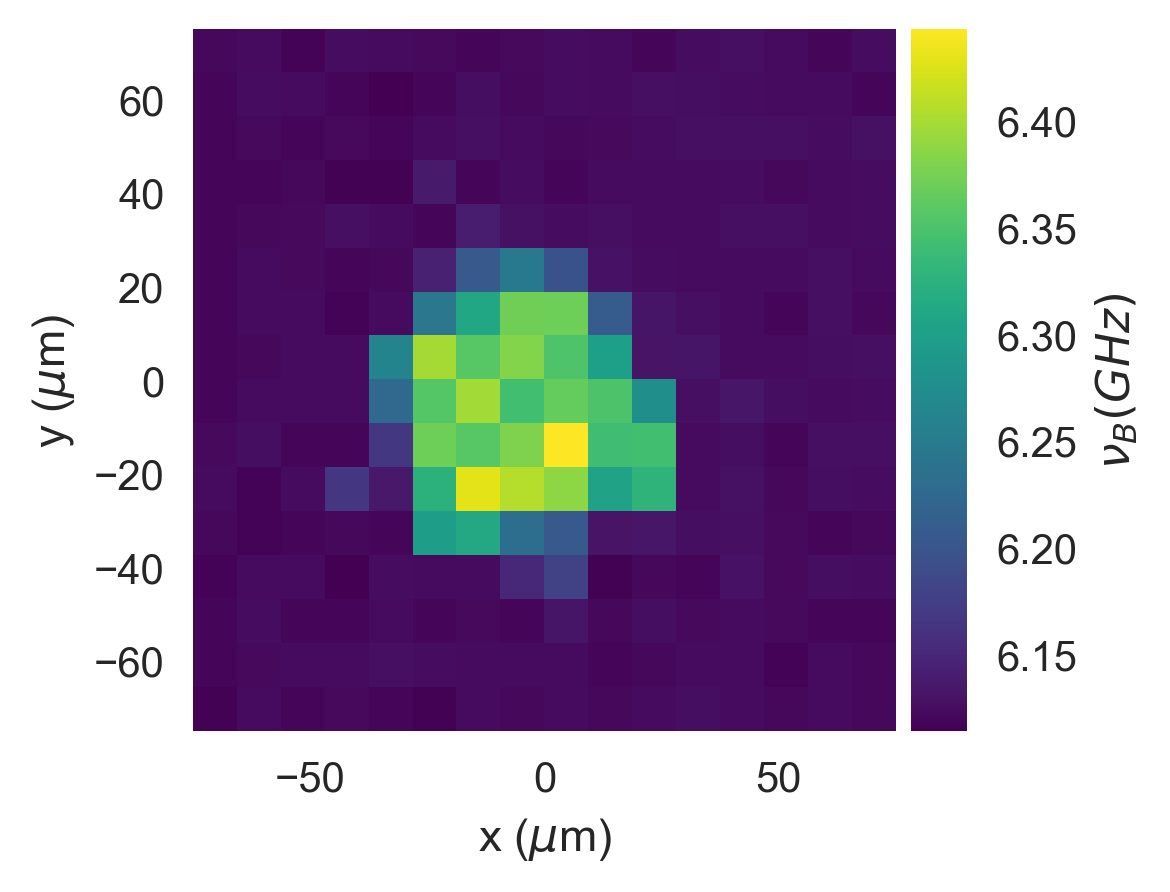

,ID,Time (HH:MM:SS),X (mm),Y (mm),Shift (GHz),FWHM (GHz),Ampl.
0,1,18:26:06,-0.075,-0.075,6.121,0.456,2525.781
1,2,18:26:07,-0.065,-0.075,6.124,0.477,2510.115
2,3,18:26:09,-0.055,-0.075,6.117,0.449,2494.426
3,4,18:26:10,-0.045,-0.075,6.125,0.463,2405.852
4,5,18:26:11,-0.035,-0.075,6.123,0.463,2437.747


In [56]:
#Read data and create sub-data frame with X, Y and Shift; add columns in um (from mm)
data = pd.read_csv(fc.selected)
datasub = data[[" X (mm)", " Y (mm)", " Shift (GHz)"]]
datasub["X (um)"]=datasub.iloc[:,0]* 1000.0
datasub["Y (um)"]=datasub.iloc[:,1]* 1000.0

#Pivot sub-data frame so that it can be plotted as a map with correct x and y coordinates
piv = datasub.pivot(index = "Y (um)",columns="X (um)",values=" Shift (GHz)")
fig,ax = plt.subplots(1,1, figsize=(4,4))
im = ax.imshow(piv,cmap="viridis",extent=[min(datasub["X (um)"]),max(datasub["X (um)"]),min(datasub["Y (um)"]),max(datasub["Y (um)"])])
ax.set_xlabel("x ($\mu$m)")
ax.set_ylabel("y ($\mu$m)")
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='8%', pad=0.05)
plt.colorbar(mappable=im,ax=ax,cax=cax,fraction=0.05,label=r"$\nu_B (GHz)$")
fig.tight_layout()
ax.grid(False)
plt.show()
data.head()

### 3) Run the two  cells below to save the Brillouin map  <br> 
First, enter the sample name; then, enter the preferred directory where to save the image.
The image is saved as a png file with 300 dpi.

In [ ]:
samplenamew=widgets.Text(
    placeholder='Please enter the sample name',
    disabled=False
)
namebox=widgets.HBox([widgets.Label(value="Sample Name:"), samplenamew])
display(namebox)

savedir=widgets.Text(
    placeholder='Please enter saving directory',
    disabled=False
)
savebox=widgets.HBox([widgets.Label(value="Saving directory:"), savedir])
display(savebox)

In [ ]:
sample_name=samplenamew.value+".png"
fig.savefig(os.path.join(savedir.value,sample_name), format="png",dpi=300)

### 4) Run cell below to display line profiles along x and  y

In [ ]:
#Plot profiles along X and Y
fig, axs = plt.subplots(1,2,figsize=(12,4))
color = cm.viridis(np.linspace(0,20,len(datasub["Y (um)"])))
for i, y in enumerate(piv.index):
    axs[0].plot(piv.columns,piv.loc[y,:],color=color[i],label="y = "+str(y)+" um")
axs[0].legend(loc='upper right', bbox_to_anchor=(1.5, 1))
axs[0].set_xlabel("x ($\mu$m)")

color = cm.viridis(np.linspace(0,20,len(datasub["X (um)"])))
for i, x in enumerate(piv.columns):
    axs[1].plot(piv.index,piv.loc[:,x],color=color[i],label="x = "+str(x)+" um")
axs[1].legend(loc='upper right', bbox_to_anchor=(1.5, 1))
axs[1].set_xlabel("y ($\mu$m)")

for ax in axs: 
    ax.set_ylabel(r"$\nu_B$ (GHz)")
    ax.grid(False)
fig.tight_layout()
plt.show()

### 5) Run the two  cells below to save the line plots  <br> 
First, enter the sample name; then, enter the preferred directory where to save the image.
The image is saved as a png file with 300 dpi.

In [ ]:
samplenamew=widgets.Text(
    placeholder='Please enter the sample name',
    disabled=False
)
namebox=widgets.HBox([widgets.Label(value="Sample Name:"), samplenamew])
display(namebox)

savedir=widgets.Text(
    placeholder='Please enter saving directory',
    disabled=False
)
savebox=widgets.HBox([widgets.Label(value="Saving directory:"), savedir])
display(savebox)

In [ ]:
sample_name=samplenamew.value+".png"
fig.savefig(os.path.join(savedir.value,sample_name), format="png",dpi=300)

### 6) Run cell below in order in order to interactively threshold the Brillouin map <br> 
Briefly, a simple threshold based on the 2D histogram of the flattened map is used for discriminating between background and object of interest. Plots are automatically updated and the average for both background and object is shown as the threshold is changed. <bk>
You can copy and paste those values in Prism in order to run statistics.

In [24]:
def threshold_image(threshold=6.20):
    back = piv[piv<threshold]
    sph = piv[piv>threshold]
    fig,axs= plt.subplots(1,4,figsize=(15,3))
    axs[0].hist(np.array(piv).flatten(),bins="auto",color='k')
    axs[0].axvline(threshold,color='red')
    im1=axs[1].imshow(piv,cmap="viridis",extent=[min(datasub["X (um)"]),max(datasub["X (um)"]),min(datasub["Y (um)"]),max(datasub["Y (um)"])])
    im2=axs[2].imshow(back,cmap="viridis",extent=[min(datasub["X (um)"]),max(datasub["X (um)"]),min(datasub["Y (um)"]),max(datasub["Y (um)"])])
    im3=axs[3].imshow(sph,cmap="viridis",extent=[min(datasub["X (um)"]),max(datasub["X (um)"]),min(datasub["Y (um)"]),max(datasub["Y (um)"])])
    all = [im1,im2,im3]
    titles = ["2D histogram", "Full map", "Background", "Object"]
    for i,ax in enumerate(axs):
        ax.set_title(titles[i])
        ax.grid(False)
        if i == 0:
            ax.set_ylabel("Counts")
            ax.set_xlabel(r"$\nu_B (GHz)$")
            #skip color map for histogram
            continue
        divider = make_axes_locatable(ax)
        cax = divider.append_axes('right', size='8%', pad=0.05)
        ax.set_xlabel("x $(\mu m)$")
        ax.set_ylabel("y $(\mu m)$")
        plt.colorbar(mappable=all[i-1],ax=axs[i],cax=cax,fraction=0.05,label=r"$\nu_B (GHz)$")
    fig.tight_layout()
threshold_image_interactive= widgets.interactive(threshold_image,threshold=(5,7,0.01))
display(threshold_image_interactive)                             

interactive(children=(FloatSlider(value=6.2, description='threshold', max=7.0, min=5.0, step=0.01), Output()),…

### 7) Finally, run cell below in order to compute the mean of the background and object <bk>
You can then copy and paste those values in any software of preference (e.g., Prism) for statistical tests and furhter plotting!

In [25]:
print("Threshold value (GHz): %.3f"%(threshold_image_interactive.kwargs["threshold"]))
print("Average Brillouin Shift Background (GHz): %.3f"%(np.nanmean(piv[piv<threshold_image_interactive.kwargs["threshold"]])))
print("Average Brillouin Shift Object (GHz): %.3f"%(np.nanmean(piv[piv>threshold_image_interactive.kwargs["threshold"]])))

Threshold value (GHz): 6.200
Average Brillouin Shift Background (GHz): 6.124
Average Brillouin Shift Object (GHz): 6.328


### 8) And... Run the two cells below if you want a .tsv file with individual values from object and background

In [67]:
data = pd.read_csv(fc.selected)
shift=data[" Shift (GHz)"]
fw = list(shift[shift>threshold_image_interactive.kwargs["threshold"]])
bk = list(shift[shift<threshold_image_interactive.kwargs["threshold"]])
data = {"Background (GHz)": shift[shift<threshold_image_interactive.kwargs["threshold"]],
                    "Object (GHz)": shift[shift>threshold_image_interactive.kwargs["threshold"]]}
df = pd.DataFrame(data=data)

samplenamew=widgets.Text(
    placeholder='Please enter the sample name',
    disabled=False
)
namebox=widgets.HBox([widgets.Label(value="Sample Name:"), samplenamew])
display(namebox)

savedir=widgets.Text(
    placeholder='Please enter saving directory',
    disabled=False
)
savebox=widgets.HBox([widgets.Label(value="Saving directory:"), savedir])
display(savebox)

In [64]:
fname=savedir.value+"/"+samplenamew.value+".tsv"
with open(fname, 'w') as f:
    f.write("Background (GHz) \t Object (GHz) \n")
    for x in zip_longest(*[bk, fw]):
        f.write("{0}\t{1}\n".format(*x))